In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
import scipy.optimize as opt
from tqdm.notebook import tqdm

In [55]:
def sinc(x,y,sigma=1):
    return np.exp(-(x**2+y**2)/(2*sigma**2))*(np.cos(2*np.pi*x*y))

def sinc_eggshell(x,y,sigma=1):
    return ((x**2 + y**2 + 25 * (np.sin(2*np.pi*x)**2 + np.sin(2*np.pi*y)**2))**0.5)  *  np.exp(-(x**2+y**2)/(2*sigma**2))

def LiOneDFunc(x):
    return (1.5*(x+2.5))**2 * ((6*x-2)**2 * np.sin(12*x-4)+10)

def Himmelblau(x,y):
    return 20-((x**2+y-11)**2 + (x+y**2-7)**2)

def Camel(x,y):
    return 20-( 2 * x**2 - 1.05 * x**4 + x**6 * 1/6 + x*y + y**2)

def McCormick(x,y):
    return -1*(np.sin(x+y)+(x-y)**2 - 1.5*x + 2.5*x + 1)

pi = np.pi
cos = np.cos
def Brannin(x,y):
    a = 1 
    b = 5.1/(4*pi**2)
    c = 5/pi
    r = 6
    s = 10
    t = 1/(8*pi)
    return a*(y-b * x**2 + c*x - r)**2 + s*(1-t)*cos(x) + s

In [24]:
# numerical optimization of the function:
func = lambda x: -1*Himmelblau(x[0],x[1])
sols = opt.minimize(func,x0=[1,1])

In [6]:
sols.x

array([-0.23817107, -0.23817107])

In [25]:
def pred_ints(model,X_list,mdtype):
    if(mdtype=="RF"):
        est_num = len(model.estimators_)
        preds = np.zeros((est_num,len(X_list)))
        for i,pred in enumerate(model.estimators_):
            preds[i] = pred.predict(X_list)

        means = np.mean(preds,axis=0)
        std = np.std(preds,axis=0)
    elif(mdtype=="GP"):
        means,std = model.predict(X_list,return_std=True)
    return means, std

def gamma(x_list,model,fstar,epsilon=0.01):
    return model.predict(x_list)-fstar+epsilon

def z(x_list,model,fstar,mdl='GP'):
    mu, sigma = pred_ints(model,x_list,mdtype=mdl)
    return gamma(x_list,model,fstar)/sigma

def EI(x_list,model, fstar,mdl='GP'):
    mu, sigma = pred_ints(model,x_list,mdtype=mdl)
    zl = z(x_list,model,fstar)
    eis = np.zeros_like(mu)
    gl = gamma(x_list,model,fstar)
    for i,gam,zz,ss in zip(list(range(len(mu))),gl,zl,sigma):
        if(ss>0):
            eis[i] = gam*norm.cdf(zz)+ss*norm.pdf(zz)
        else:
            eis[i] = gam
    return eis

def EI_slider(x_list,model, eta, fstar,mdl='GP'):
    mu, sigma = pred_ints(model,x_list,mdtype=mdl)
    zl = z(x_list,model,fstar)
    eis = np.zeros_like(mu)
    gl = gamma(x_list,model,fstar)
    for i,gam,zz,ss in zip(list(range(len(mu))),gl,zl,sigma):
        if(ss>0):
            eis[i] = gam*norm.cdf(zz)+eta*ss*norm.pdf(zz)
        else:
            eis[i] = gam
    return eis

def EI_single(x, model, fstar, mdl='GP'):
    mu, sigma = pred_ints(model,[x],mdtype=mdl)
    zl = z([x],model,fstar)
    eis = np.zeros_like(mu)
    gl = gamma([x],model,fstar)
    for i,gam,zz,ss in zip(list(range(len(mu))),gl,zl,sigma):
        if(ss>0):
            eis[i] = gam*norm.cdf(zz)+ss*norm.pdf(zz)
        else:
            eis[i] = gam
    return eis


def EI_single_slider(x, model, eta, fstar, mdl='GP'):
    mu, sigma = pred_ints(model,[x],mdtype=mdl)
    zl = z([x],model,fstar)
    eis = np.zeros_like(mu)
    gl = gamma([x],model,fstar)
    for i,gam,zz,ss in zip(list(range(len(mu))),gl,zl,sigma):
        if(ss>0):
            eis[i] = gam*norm.cdf(zz)+eta*ss*norm.pdf(zz)
        else:
            eis[i] = gam
    return eis

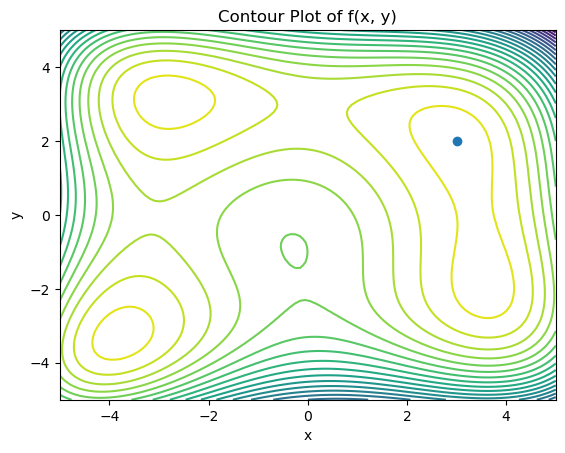

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x and y values for the function
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

# Compute the function values for the grid
Z = Himmelblau(X, Y)

# Create a 3D plot of the function
fig = plt.figure()
ax = fig.add_subplot(111)
ax.contour(X, Y, Z,levels=25)
ax.plot(sols.x[0],sols.x[1],'o')

# Add labels and a title
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Surface Plot of f(x, y)')


# Add labels and a title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Contour Plot of f(x, y)')

# Show the plot
plt.show()

# BO bootstrapping 
 Now what we want to do is to take the data set, sample for each random episode of training of the exploration and exploitation tuner a random subset in which we can optimize a new iteration of the surrogate model.
 So we initialize an example based on a two dimensional problem 


In [75]:
def BootsStrappedBO(function_to_bootstrap):
    # Using nelder-mead to optimize the function
    func = lambda x: -1*function_to_bootstrap(x[0],x[1])
    sols = opt.minimize(func,x0=[1,1],method='Nelder-Mead')
    # Definition of the inital data set
    # This is the complete dataset from which we will bootstrap samples.
    x_init_o = np.random.random((20,2))*4-2
    y_init_o = [function_to_bootstrap(*x_) for x_ in x_init_o]

    # Take :-10 points for the training 
    x_init = x_init_o[:-10]
    y_init = y_init_o[:-10]

    # Take 10 points as heldout for validation
    HO_x = x_init_o[-10:]
    HO_y = y_init_o[-10:]

    # Initialize a regressor. 
    init_model = GaussianProcessRegressor()
    init_model.fit(x_init,y_init)

    # Make different iterations with NEP different bootstrapped data points.
    NEP = 30

    # Number of iterations over which opotimization will be done. 
    BO_epochs = 40

    # Arrays with accumulated maximums and their position to keep track of the trajectories.
    ymax_accum = []
    xmax_accum = []
    xadded_accum = []
    predictions = np.zeros((NEP,len(HO_y)))
    appended_types = []

    # Initialize a bootstrapped instance. 
    # We will go with the bootstrapping used typically on random forests, where there is 
    # replacement and we will do regular bayesian optimization

    for j in tqdm(range(NEP),desc='Episode'):
        indices = np.random.choice(list(range(10)),size=10,replace=True)
        x_ep = x_init[indices]
        y_ep = [y_init[ii] for ii in indices]
        second_sur = GaussianProcessRegressor()
        second_sur.fit(x_ep,y_ep)
        xadded = np.zeros((BO_epochs,2))
        xmaxs = np.zeros((BO_epochs,2))
        ymaxs = np.zeros(BO_epochs)
        append_t = np.zeros((BO_epochs,2))
        for i in range(BO_epochs):
            # Define the acquisition function
            f = lambda x: -1*EI_single(x,second_sur,max(y_ep))
            # Find the point that maximizes the expected improvement. 
            xx = opt.minimize(f,x0=x_ep[np.argmax(y_ep)],method='Nelder-Mead')
            oracle_call = function_to_bootstrap(*xx.x)
            x_ep = np.append(x_ep,[xx.x[:2]],axis=0)
            y_ep = np.append(y_ep,[oracle_call],axis=0)
            second_sur.fit(x_ep,y_ep)
            ymaxs[i] = max(y_ep)
            xmaxs[i] = x_ep[np.argmax(y_ep)]
            xadded[i] = xx.x
        
        appended_types.append(append_t)
        ymax_accum.append(ymaxs)
        xmax_accum.append(xmaxs)
        xadded_accum.append(xadded)
        predictions[j] = second_sur.predict(HO_x)

    bootstrap = np.mean(predictions,axis=0)
    error_BS = mean_squared_error(HO_y,bootstrap)
        
        
    # And the single bayesian optimization iterations
    x_ep = x_init.copy()
    y_ep = y_init.copy()
    for i in range(BO_epochs):
        # Define the acquisition function
        f = lambda x: -1*EI_single(x,init_model,max(y_ep))
        # Find the point that maximizes the expected improvement. 
        xx = opt.minimize(f,x0=x_ep[np.argmax(y_ep)],method='Nelder-Mead')
        oracle_call = function_to_bootstrap(*xx.x)
        x_ep = np.append(x_ep,[xx.x[:2]],axis=0)
        y_ep = np.append(y_ep,[oracle_call],axis=0)
        init_model.fit(x_ep,y_ep)
        ymax_single = max(y_ep)
        xmax_single = x_ep[np.argmax(y_ep)]

    maximums = [ymaxs[-1] for ymaxs in ymax_accum]
    positions = [xmaxs[-1] for xmaxs in xmax_accum]

    error_REG = mean_squared_error(HO_y,init_model.predict(HO_x))

    # Generate x and y values for the function
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x, y)

    # Compute the function values for the grid
    Z = function_to_bootstrap(X, Y)

    # Create a 3D plot of the function
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.contour(X, Y, Z,cmap='Blues',levels=15)
    ax.plot(sols.x[0],sols.x[1],'o')

    # Add labels and a title
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Surface Plot of f(x, y)')
    for i,pos in enumerate(positions):
        ax.plot([pos[0]],[pos[1]],'p',color=plt.cm.jet(i/len(positions)))

    ax.plot(xmax_single[0],xmax_single[1],'^',color='k')
    # Add labels and a title
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Contour Plot of f(x, y)')

    # Show the plot
    plt.show()
    return error_BS, error_REG

Episode:   0%|          | 0/30 [00:00<?, ?it/s]

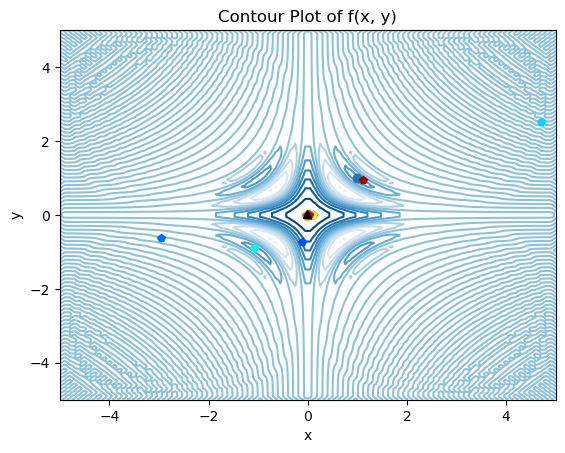

(1.0690551937755806, 26.675474164631574)

In [65]:
BootsStrappedBO(sinc)

Episode:   0%|          | 0/30 [00:00<?, ?it/s]

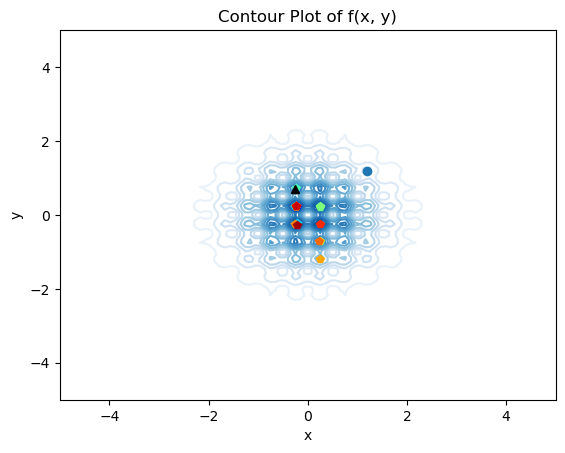

(2591.6274242837453, 1905.0780936635529)

In [66]:
BootsStrappedBO(sinc_eggshell)

Episode:   0%|          | 0/30 [00:00<?, ?it/s]

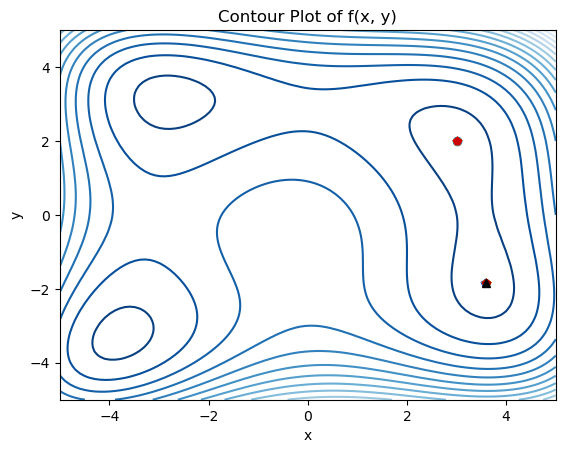

(749.2844202277067, 265.2781160093865)

In [67]:
BootsStrappedBO(Himmelblau)

Episode:   0%|          | 0/30 [00:00<?, ?it/s]

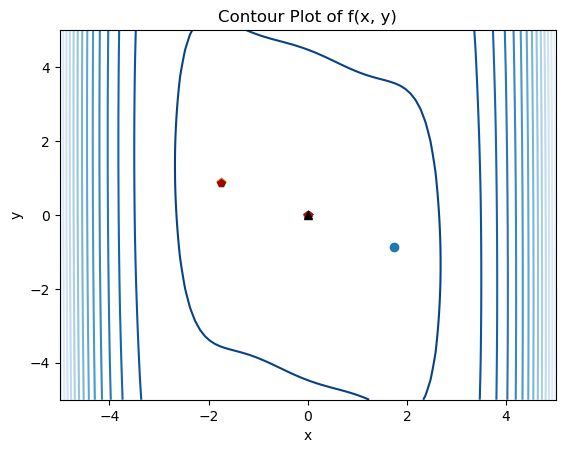

(4.45500650696665, 2.591036504815162)

In [68]:
BootsStrappedBO(Camel)

Episode:   0%|          | 0/30 [00:00<?, ?it/s]

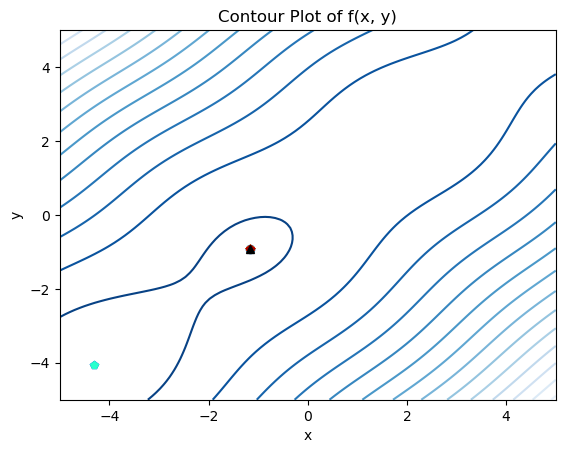

(6.205748822491812, 4.588407778278482)

In [69]:
BootsStrappedBO(McCormick)

In [73]:
def BootsStrappedBO_active(function_to_bootstrap):
    # Using nelder-mead to optimize the function
    func = lambda x: -1*function_to_bootstrap(x[0],x[1])
    sols = opt.minimize(func,x0=[1,1],method='Nelder-Mead')
    # Definition of the inital data set
    # This is the complete dataset from which we will bootstrap samples.
    x_init_o = np.random.random((20,2))*4-2
    y_init_o = [function_to_bootstrap(*x_) for x_ in x_init_o]

    # Take :-10 points for the training 
    x_init = x_init_o[:-10]
    y_init = y_init_o[:-10]

    # Take 10 points as heldout for validation
    HO_x = x_init_o[-10:]
    HO_y = y_init_o[-10:]

    # Initialize a regressor. 
    init_model = GaussianProcessRegressor()
    init_model.fit(x_init,y_init)

    # Make different iterations with NEP different bootstrapped data points.
    NEP = 30
    SAMP = 5
    # Define the budget
    B = 30
    # Define the criterium parameters for selecting which points to sample the oracle on. 
    tol_dist = 1e-4
    tol_uncert = 1e-3

    # Number of iterations over which opotimization will be done. 
    BO_epochs = 40

    # Arrays with accumulated maximums and their position to keep track of the trajectories.
    ymax_accum = []
    xmax_accum = []
    xadded_accum = []
    predictions = np.zeros((NEP,len(HO_y)))
    budgets = np.zeros((NEP))
    appended_types = []

    # Initialize a bootstrapped instance. 
    # We will go with the bootstrapping used typically on random forests, where there is 
    # replacement and we will do regular bayesian optimization

    for j in tqdm(range(NEP),desc='Episode'):
        indices = np.random.choice(list(range(10)),size=10,replace=True)
        x_ep = x_init[indices]
        y_ep = [y_init[ii] for ii in indices]
        second_sur = GaussianProcessRegressor()
        second_sur.fit(x_ep,y_ep)
        xadded = np.zeros((BO_epochs,2))
        xmaxs = np.zeros((BO_epochs,2))
        ymaxs = np.zeros(BO_epochs)
        append_t = np.zeros((BO_epochs,2))
        budgets[j] = B
        for i in range(BO_epochs):
            # Define the acquisition function
            f = lambda x: -1*EI_single(x,second_sur,max(y_ep))
            # Find the point that maximizes the expected improvement. 
            xx = opt.minimize(f,x0=x_ep[np.argmax(y_ep)],method='Nelder-Mead')
            dist_to_dataset = np.sqrt(np.sum((x_init-xx.x[:2])**2,axis=-1))
            m_pred = init_model.predict([xx.x[:2]],return_std=True)
            if(min(dist_to_dataset)<tol_dist):
                append_t[i,:] = 0,min(dist_to_dataset)
                indx = np.argmin(dist_to_dataset)
                #print(x_init[indx],y_init[indx])
                x_ep = np.append(x_ep,[x_init[indx]],axis=0)
                y_ep = np.append(y_ep,[y_init[indx]],axis=0)
            elif(m_pred[1]<tol_uncert):
                #print(m_pred[1])
                append_t[i,:] = 1, m_pred[1][0]
                x_ep = np.append(x_ep,[xx.x[:2]],axis=0)
                y_ep = np.append(y_ep,m_pred[0],axis=0)
            else:
                oracle_call = function_to_bootstrap(*xx.x)
                budgets[j] += -1
                append_t[i,:] = 2,B
                x_ep = np.append(x_ep,[xx.x[:2]],axis=0)
                y_ep = np.append(y_ep,[oracle_call],axis=0)
                x_init = np.append(x_init,[xx.x[:2]],axis=0)
                y_init = np.append(y_init,[oracle_call],axis=0)
                init_model.fit(x_init,y_init)
                if(budgets[j]==0): break

            x_ep = np.append(x_ep,[xx.x[:2]],axis=0)
            y_ep = np.append(y_ep,[oracle_call],axis=0)
            second_sur.fit(x_ep,y_ep)
            ymaxs[i] = max(y_ep)
            xmaxs[i] = x_ep[np.argmax(y_ep)]
            xadded[i] = xx.x
        
        appended_types.append(append_t)
        ymax_accum.append(ymaxs)
        xmax_accum.append(xmaxs)
        xadded_accum.append(xadded)
        predictions[j] = second_sur.predict(HO_x)

    print(budgets)
    bootstrap = np.mean(predictions,axis=0)
    error_BS = mean_squared_error(HO_y,bootstrap)
        
        
    # And the single bayesian optimization iterations
    x_ep = x_init.copy()
    y_ep = y_init.copy()
    for i in range(BO_epochs):
        # Define the acquisition function
        f = lambda x: -1*EI_single(x,init_model,max(y_ep))
        # Find the point that maximizes the expected improvement. 
        xx = opt.minimize(f,x0=x_ep[np.argmax(y_ep)],method='Nelder-Mead')
        oracle_call = function_to_bootstrap(*xx.x)
        x_ep = np.append(x_ep,[xx.x[:2]],axis=0)
        y_ep = np.append(y_ep,[oracle_call],axis=0)
        init_model.fit(x_ep,y_ep)
        ymax_single = max(y_ep)
        xmax_single = x_ep[np.argmax(y_ep)]

    maximums = [ymaxs[-1] for ymaxs in ymax_accum]
    positions = [xmaxs[-1] for xmaxs in xmax_accum]

    error_REG = mean_squared_error(HO_y,init_model.predict(HO_x))

    # Generate x and y values for the function
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x, y)

    # Compute the function values for the grid
    Z = function_to_bootstrap(X, Y)

    # Create a 3D plot of the function
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.contour(X, Y, Z,cmap='Blues',levels=15)
    ax.plot(sols.x[0],sols.x[1],'o')

    # Add labels and a title
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Surface Plot of f(x, y)')
    for i,pos in enumerate(positions):
        ax.plot([pos[0]],[pos[1]],'p',color=plt.cm.jet(i/len(positions)))

    ax.plot(xmax_single[0],xmax_single[1],'^',color='k')
    # Add labels and a title
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Contour Plot of f(x, y)')

    # Show the plot
    plt.show()
    return error_BS, error_REG

Episode:   0%|          | 0/30 [00:00<?, ?it/s]

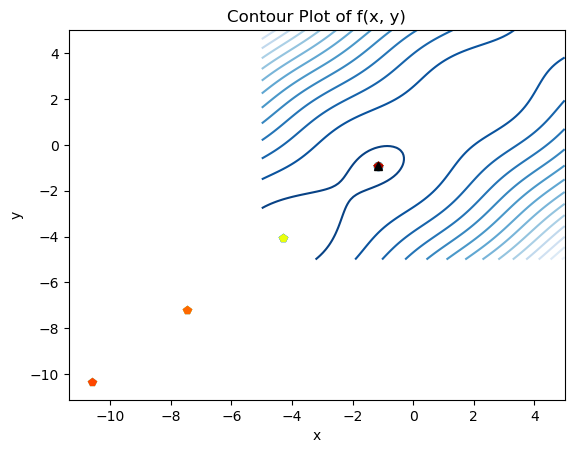

(3.482825279074338, 1.8984127863791749)

In [77]:
BootsStrappedBO(McCormick)

Episode:   0%|          | 0/30 [00:00<?, ?it/s]

[15.  8. 24.  0. 20.  2. 30.  6. 30. 21. 29. 13. 30. 30. 30. 30. 30. 19.
 29. 30. 30. 28. 30.  5. 30. 30. 30. 30. 30. 30.]


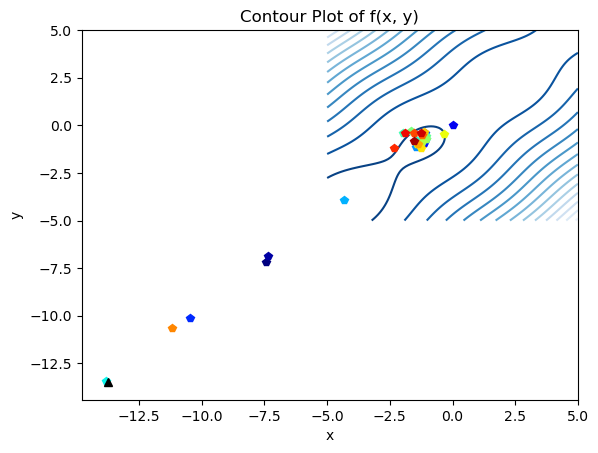

(22.568925916795532, 0.22293912361095652)

In [74]:
BootsStrappedBO_active(McCormick)

In [82]:
print(sum([30-a for a in [15.,8.,24.,0.,20.,2.,30.,6.,30.,21.,29.,13.,30.,30.,30.,30.,30.,19.,29.,30.,30.,28.,30.,5.,30.,30.,30.,30.,30.,30.]]))
print(sum([30 for a in [15.,8.,24.,0.,20.,2.,30.,6.,30.,21.,29.,13.,30.,30.,30.,30.,30.,19.,29.,30.,30.,28.,30.,5.,30.,30.,30.,30.,30.,30.]]))

201.0
900


In [ ]:
# Definition of the inital data set
# This is the complete dataset from which we will bootstrap samples.
x_init_o = np.random.random((20,2))*4-2
y_init_o = [Himmelblau(*x_) for x_ in x_init_o]

# Take :-10 points for the training 
x_init = x_init_o[:-10]
y_init = y_init_o[:-10]

# Hold 10 points to do the validation. 
HO_x = x_init_o[-10:]
HO_y = y_init_o[-10:]

# Make a single data set
Dat = list(zip(x_init,y_init))

# Initialize a regressor. 
init_model = GaussianProcessRegressor()
init_model.fit(x_init,y_init)

# Make different iterations with NEP different bootstrapped data points.
NEP = 30
SAMP = 5
B = 30

# Number of iterations over which opotimization will be done. 
BO_epochs = 40
tol_dist = 1e-4
tol_uncert = 1e-3

# Arrays with accumulated maximums and their position to keep track of the trajectories.
ymax_accum = []
xmax_accum = []
xadded_accum = []

appended_types = []

# Initialize a bootstrapped instance. 
# We will go with the bootstrapping used typically on random forests, where there is 
# replacement and we will do regular bayesian optimization

for i in tqdm(range(NEP),desc='Episode'):
    indices = np.random.choice(list(range(10)),size=10,replace=True)
    x_ep = x_init[indices]
    y_ep = [y_init[ii] for ii in indices]
    second_sur = GaussianProcessRegressor()
    second_sur.fit(x_ep,y_ep)
    xadded = np.zeros((BO_epochs,3))
    xmaxs = np.zeros((BO_epochs,2))
    ymaxs = np.zeros(BO_epochs)
    append_t = np.zeros((BO_epochs,2))
    for i in range(BO_epochs):
        # Define the acquisition function
        f = lambda x: -1*EI_single(x,second_sur,max(y_ep))
        # Find the point that maximizes the expected improvement. 
        xx = opt.minimize(f,x0=x_ep[np.argmax(y_ep)],method='Nelder-Mead')
        oracle_call = Himmelblau(*xx.x)
        x_ep = np.append(x_ep,[xx.x[:2]],axis=0)
        y_ep = np.append(y_ep,[oracle_call],axis=0)
        dist_to_dataset = np.sqrt(np.sum((x_init-xx.x[:2])**2,axis=-1))
        m_pred = init_model.predict([xx.x[:2]],return_std=True)
        xadded[i]=xx.x
        #print(len(x_init),len(y_init))
        
        if(min(dist_to_dataset)<tol_dist):
            append_t[i,:] = 0,min(dist_to_dataset)
            indx = np.argmin(dist_to_dataset)
            #print(x_init[indx],y_init[indx])
            x_ep = np.append(x_ep,[x_init[indx]],axis=0)
            y_ep = np.append(y_ep,[y_init[indx]],axis=0)
        
        elif(m_pred[1]<tol_uncert):
            #print(m_pred[1])
            append_t[i,:] = 1, m_pred[1][0]
            x_ep = np.append(x_ep,[xx.x[:2]],axis=0)
            y_ep = np.append(y_ep,m_pred[0],axis=0)
        
        else:
            oracle_call = sinc_eggshell(*xx.x)
            B = B-1
            append_t[i,:] = 2,B
            x_ep = np.append(x_ep,[xx.x[:2]],axis=0)
            y_ep = np.append(y_ep,[oracle_call],axis=0)
            x_init = np.append(x_init,[xx.x[:2]],axis=0)
            y_init = np.append(y_init,[oracle_call],axis=0)
            init_model.fit(x_init,y_init)
            if(B==0): break

        second_sur.fit(x_ep,y_ep)
        ymaxs[i] = max(y_ep)
        xmaxs[i] = x_ep[np.argmax(y_ep)]
    
    appended_types.append(append_t)
    ymax_accum.append(ymaxs)
    xmax_accum.append(xmaxs)
    xadded_accum.append(xadded)
    
    

